# 연구목적 : 장입온도를 예측해서 추후 공정과정에 HCR or CCR만 집어 넣을 것인가
- 장입온도는 두께, 폭, 넓이, 길이, RolljoblinLT, SHEARinLT의 영향을 받음
- 슬라브의 온도가 300도 이상 -> HCR
- 슬라브의 온도가 300도 미만 -> CCR
- 장입온도 측정 이전에 input들로 예상 장입온도를 측정해서, 프로세스를 일원화하고자 함

# 연구과정 정의:

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
# 데이터 분할
from sklearn.model_selection import train_test_split
# qq plot , 회귀분석 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형모델
import statsmodels.formula.api as smf
# 평가함수
from statsmodels.tools.eval_measures import rmse
# 결정계수 평가지표
from sklearn.metrics import r2_score
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
matplotlib.rc('font',family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
# 데이터 불러오기
df = pd.read_csv('hotrolling.csv')
df.head()

,temp,SLABweight,SLABwide,SLABthick,SLABlong,RolljoblinLT,SHEARinLT,TSmean
0,571,30.6 ton,1570 mm,250 mm,9970 mm,14.3,8.0,255
1,351,23.65 ton,1020 mm,250 mm,11860 mm,10.3,13.4,340
2,460,34.63 ton,1500 mm,250 mm,11810 mm,14.6,7.5,253
3,488,28.94 ton,1570 mm,250 mm,9430 mm,14.4,7.8,252
4,335,34.81 ton,1500 mm,250 mm,11870 mm,14.7,7.2,253


## 데이터 특성 확인

In [7]:
# 결측치 확인

# SLABweight 1
# SLABthick 1

# 결측치 제거
df_raw=df.dropna()
df_raw.isnull().sum()

temp            0
SLABweight      0
SLABwide        0
SLABthick       0
SLABlong        0
RolljoblinLT    0
SHEARinLT       0
TSmean          0
dtype: int64

In [14]:
# 단위 떼어내기
df_raw[['SLABwide', 'SLABwide_unit']] = df_raw['SLABwide'].str.split(expand = True)
df_raw[['SLABthick', 'SLABthick_unit']] = df_raw['SLABthick'].str.split(expand = True)
df_raw[['SLABweight', 'SSLABweight_unit']] = df_raw['SLABweight'].str.split(expand = True)
df_raw[['SLABlong', 'SLABlong_unit']] = df_raw['SLABlong'].str.split(expand = True)

ValueError: Columns must be same length as key

In [28]:
df_raw.head()

,temp,SLABweight,SLABwide,SLABthick,SLABlong,RolljoblinLT,SHEARinLT,TSmean,SLABlong_unit,SLABwide_unit,SLABthick_unit,SSLABweight_unit,label
0,571,30.60,1570.0,250.0,9970.0,14.3,8.0,255,mm,mm,mm,ton,1
1,351,23.65,1020.0,250.0,11860.0,10.3,13.4,340,mm,mm,mm,ton,1
2,460,34.63,1500.0,250.0,11810.0,14.6,7.5,253,mm,mm,mm,ton,1
3,488,28.94,1570.0,250.0,9430.0,14.4,7.8,252,mm,mm,mm,ton,1
4,335,34.81,1500.0,250.0,11870.0,14.7,7.2,253,mm,mm,mm,ton,1


In [30]:

# SLABweight,SLABwide,SLABthick,SLABlong obf -> float으로 변환
df_raw['SLABweight'] = df_raw['SLABweight'].astype('float64');
df_raw['SLABwide'] = df_raw['SLABwide'].astype('float64');
df_raw['SLABthick'] = df_raw['SLABthick'].astype('float64');
df_raw['SLABlong'] = df_raw['SLABlong'].astype('float64');
# type 변환
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1001 entries, 0 to 1002
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              1001 non-null   int64  
 1   SLABweight        1001 non-null   float64
 2   SLABwide          1001 non-null   float64
 3   SLABthick         1001 non-null   float64
 4   SLABlong          1001 non-null   float64
 5   RolljoblinLT      1001 non-null   float64
 6   SHEARinLT         1001 non-null   float64
 7   TSmean            1001 non-null   int64  
 8   SLABlong_unit     1001 non-null   object 
 9   SLABwide_unit     1001 non-null   object 
 10  SLABthick_unit    1001 non-null   object 
 11  SSLABweight_unit  1001 non-null   object 
 12  label             1001 non-null   int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 109.5+ KB


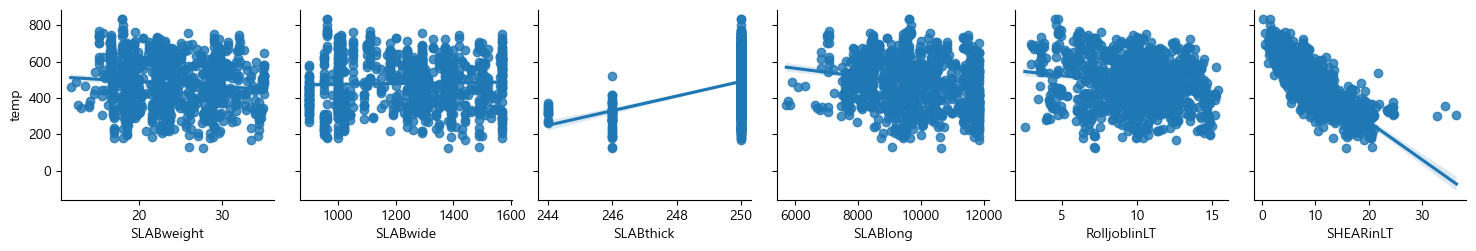

In [19]:
sns.pairplot(df_raw, y_vars = 'temp', x_vars = ['SLABweight','SLABwide','SLABthick','SLABlong','RolljoblinLT','SHEARinLT'], kind = 'reg');


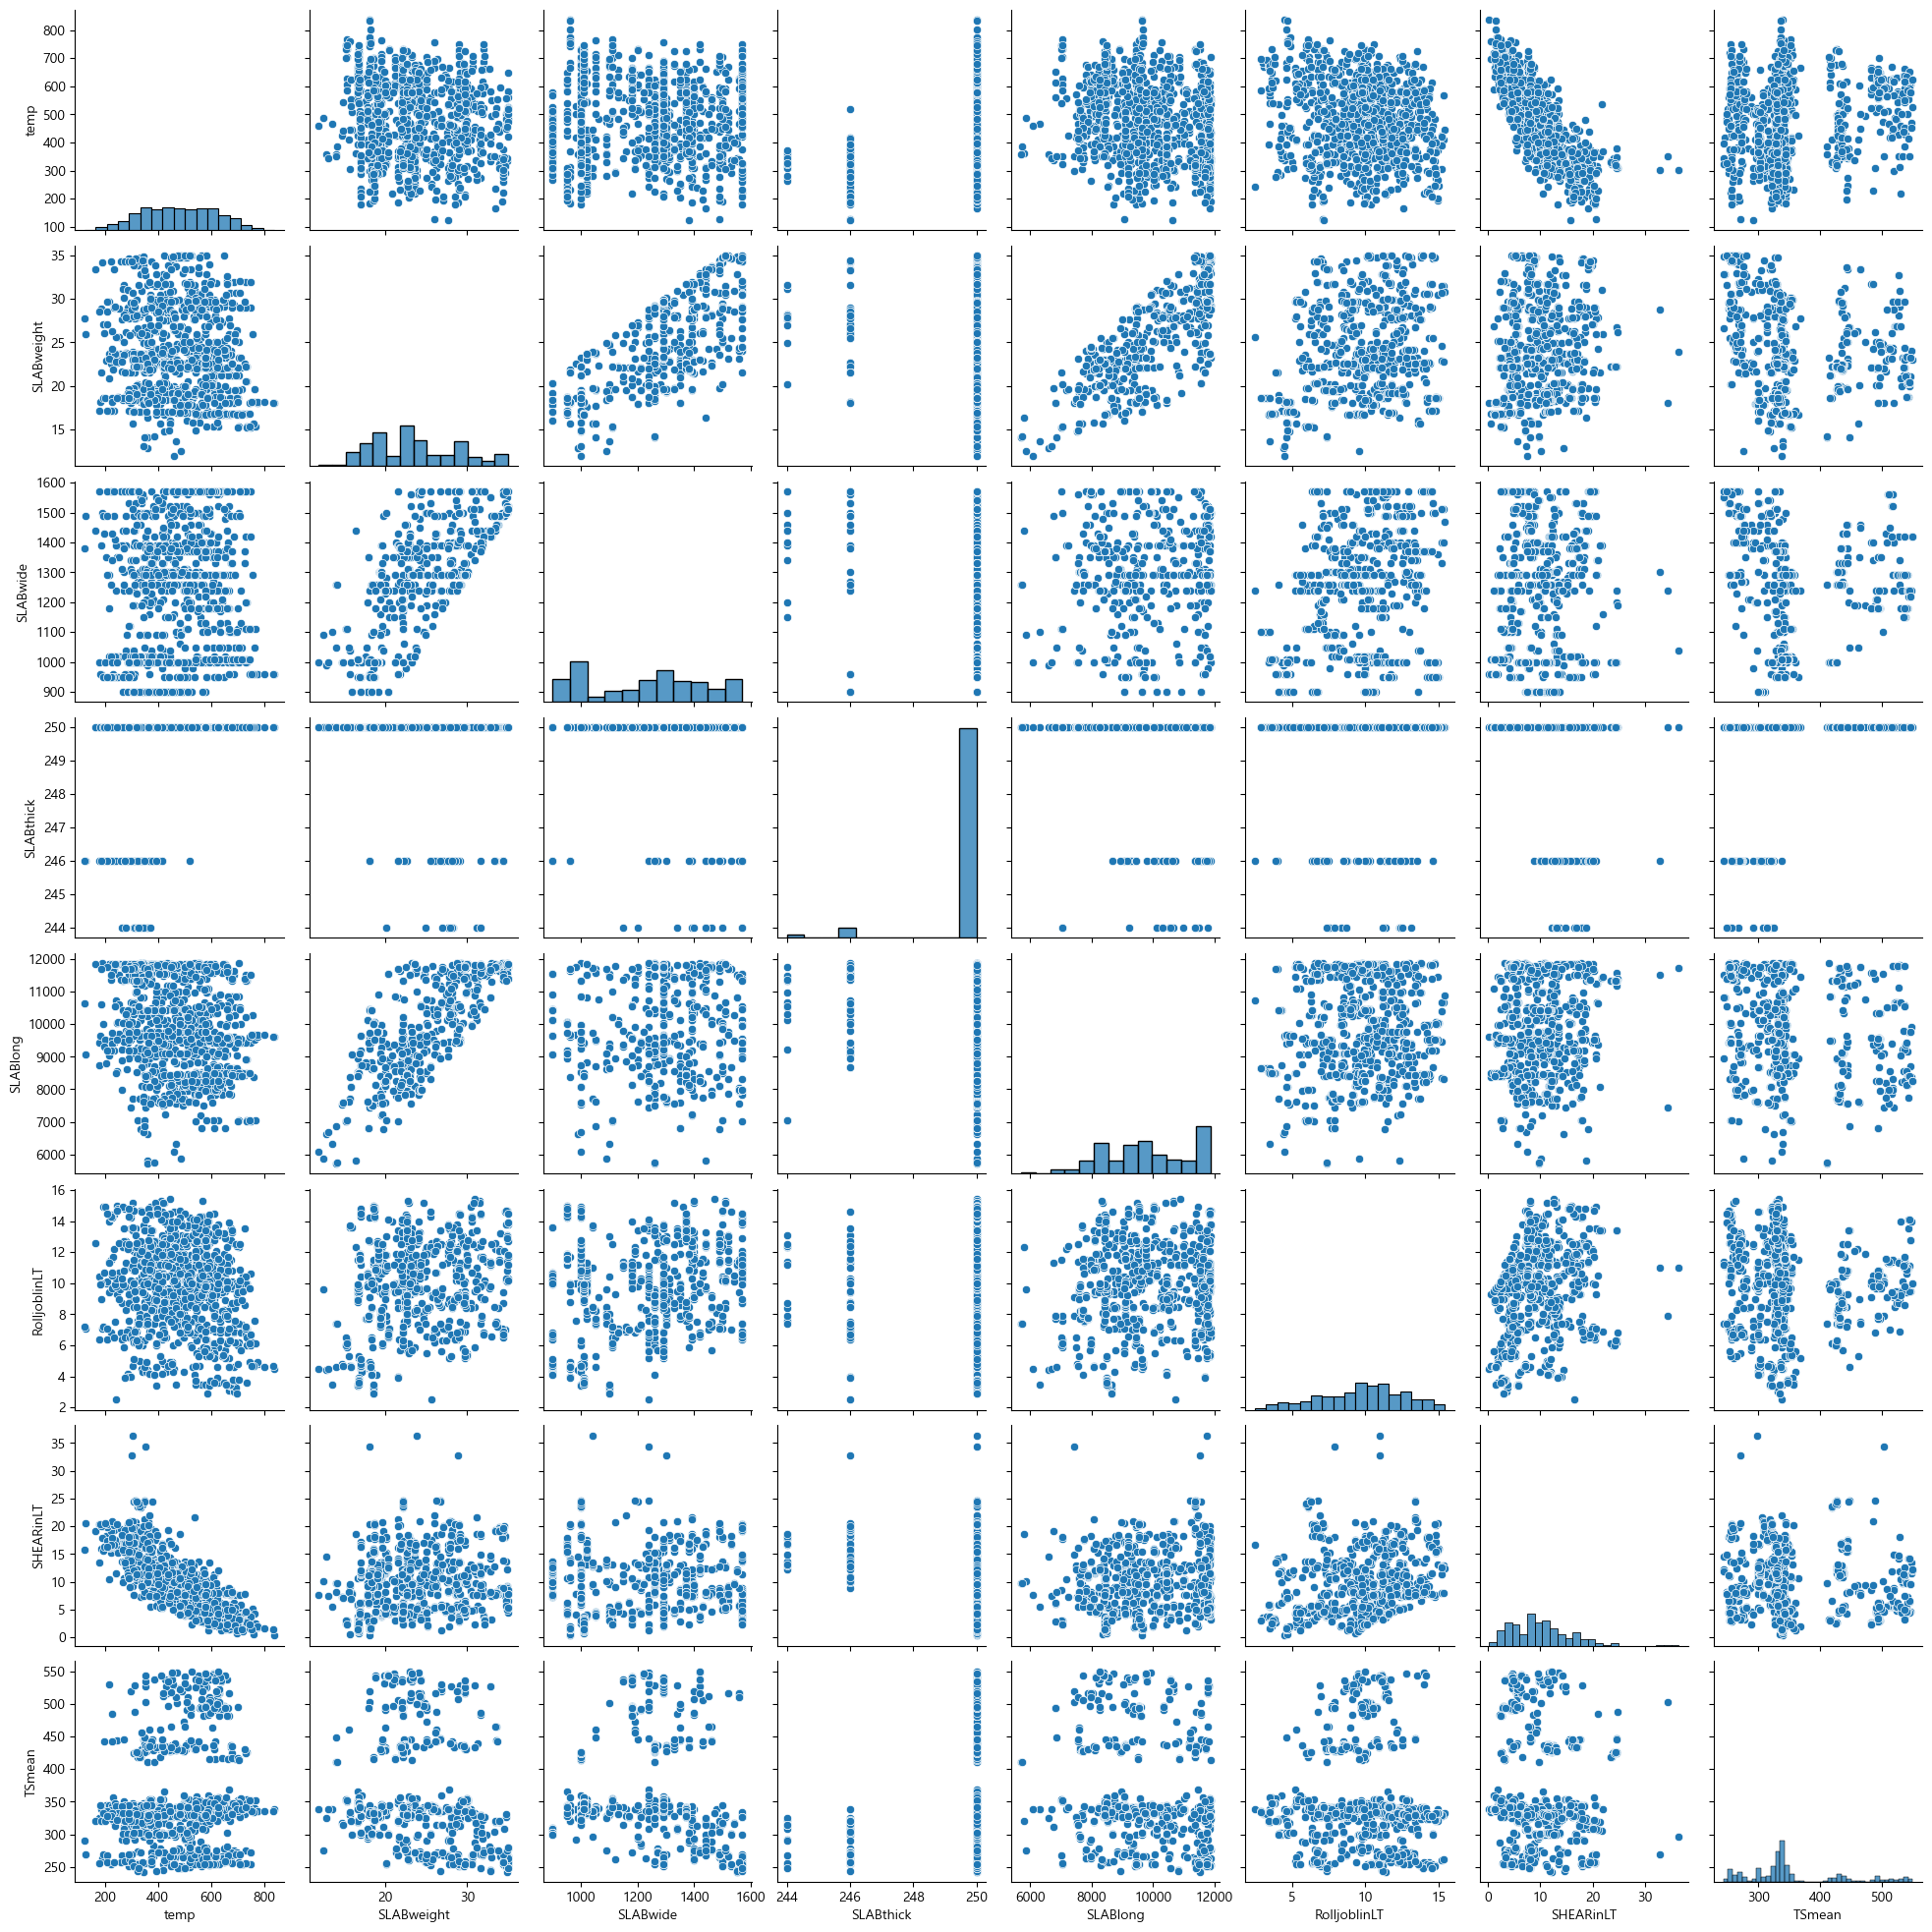

In [20]:
sns.pairplot(df_raw);

In [23]:
# 300도 이상의 값을 label '1' 300도 미만의 값을 Label '2' for 2Sample TTEST
df_raw['label'] = 0
df_raw.loc[df['temp'] >= 300, 'label'] = 1
df_raw.loc[df['temp'] < 300, 'label'] = 2


In [45]:
# 상관관계 분석
# unit 칼럼 삭제
df_raw = df_raw.drop(['SSLABweight_unit', 'SLABwide_unit' , 'SLABthick_unit', 'SLABlong_unit'] , axis = 1)

df_raw.corr().round(3)
# temp / SHEARinLT = -0.797 | temp / SLABwide = 0.741

,temp,SLABweight,SLABwide,SLABthick,SLABlong,RolljoblinLT,SHEARinLT,TSmean,label
temp,1.000,-0.103,0.031,0.313,-0.222,-0.184,-0.797,0.134,-0.540
SLABweight,-0.103,1.000,0.741,-0.172,0.651,0.254,0.155,-0.167,0.049
SLABwide,0.031,0.741,1.000,-0.159,-0.018,0.301,0.060,-0.098,-0.027
SLABthick,0.313,-0.172,-0.159,1.000,-0.115,0.017,-0.306,0.206,-0.261
SLABlong,-0.222,0.651,-0.018,-0.115,1.000,0.057,0.210,-0.135,0.120
RolljoblinLT,-0.184,0.254,0.301,0.017,0.057,1.000,0.206,-0.047,0.060
SHEARinLT,-0.797,0.155,0.060,-0.306,0.210,0.206,1.000,-0.098,0.415
TSmean,0.134,-0.167,-0.098,0.206,-0.135,-0.047,-0.098,1.000,-0.107
label,-0.540,0.049,-0.027,-0.261,0.120,0.060,0.415,-0.107,1.000


In [47]:
# 학습용/평가용 데이터 분리
df_train, df_test = train_test_split(df_raw, test_size = 0.3, random_state = 145)
print('학습용 DATA 크기 : {}'.format(df_train.shape))
print('평가용 DATA 크기 : {}'.format(df_test.shape))

학습용 DATA 크기 : (700, 9)
평가용 DATA 크기 : (301, 9)


In [93]:
# 선형 회귀 분석
reg_model = smf.ols(formula = 'temp ~ SLABweight +  SLABwide + SLABthick + SLABlong + RolljoblinLT + SHEARinLT', data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     222.2
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          9.05e-158
Time:                        10:15:54   Log-Likelihood:                -4077.3
No. Observations:                 700   AIC:                             8169.
Df Residuals:                     693   BIC:                             8200.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2975.5022    858.847     -3.465   

In [101]:
# thick안에 값이 250,246,244 밖에 없지만 연속형임 그래서 굳이 연속형 처리하지말고 범주형으로 처리
df_raw['SLABthick'].value_counts()

SLABthick
250.0    941
246.0     47
244.0     13
Name: count, dtype: int64

In [51]:
reg_model = smf.ols(formula = 'temp ~  SLABwide + SLABthick + RolljoblinLT + SHEARinLT', data = df_train)
reg_result = reg_model.fit() 
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     329.0
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          1.00e-158
Time:                        09:53:35   Log-Likelihood:                -4080.9
No. Observations:                 700   AIC:                             8172.
Df Residuals:                     695   BIC:                             8195.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2662.7055    811.223     -3.282   

## 설명변수 간의 다중공선성 확인

In [54]:
df_raw_x = df_train[['SLABwide','SLABthick', 'RolljoblinLT','SHEARinLT']]

# statsmodels의 상수항 추가 함수 적용
df_raw_x_const = add_constant(df_raw_x)

# DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif['Variable'] = df_raw_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]
# df_raw_x_const의 인덱스 값 1(5)만 큼 반복해서 각 values별로 VIF값 구하기
# VIF 정렬
df_vif.sort_values('VIF', inplace = True)
df_vif.round(3)
# VIF의 값이 1~10 미만으로 형성 되어 있기에 다중공선성이 문제가 되는 변수는 찾지 못함

,Variable,VIF
1,SLABwide,1.132
3,RolljoblinLT,1.151
2,SLABthick,1.161
4,SHEARinLT,1.177
0,const,67447.856


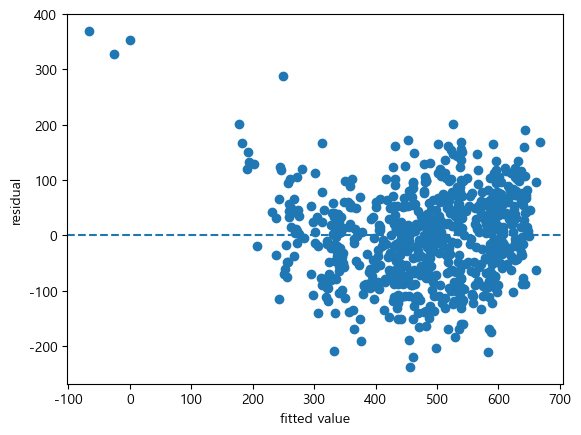

In [56]:
# 등분산성 검정
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel('fitted value')
plt.ylabel('residual')
plt.axhline(y = 0, linestyle = '--');
# 잔차가 y = 0를 기준으로 

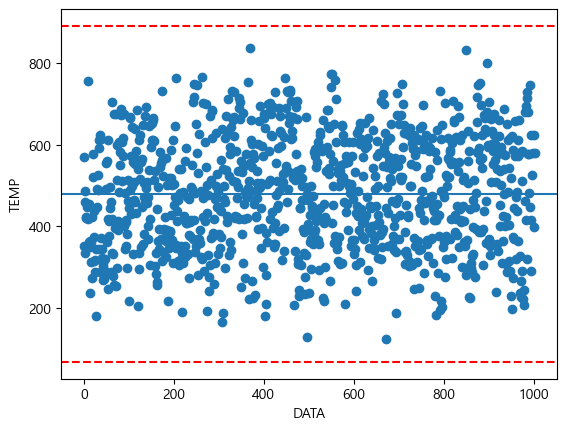

In [61]:
# 독립성 검정
# 관리도 그리기
# individual 관리도
plt.scatter(df_raw.index, df_raw.temp, marker = 'o')
plt.xlabel('DATA')
plt.ylabel('TEMP')
plt.axhline(y = np.mean(df_raw['temp']),linestyle = '-', label = 'CL')
plt.axhline(y = np.mean(df_raw['temp']) + 3*np.std(df_raw['temp']),linestyle = '--',color = 'red', label = 'UCL')
plt.axhline(y = np.mean(df_raw['temp']) + - 3*np.std(df_raw['temp']),linestyle = 'dashed',color = 'red', label = 'LCL');
# 상,하한선을 이탈하는 data가 없으므로 안정적인 공정 상태를 유지중

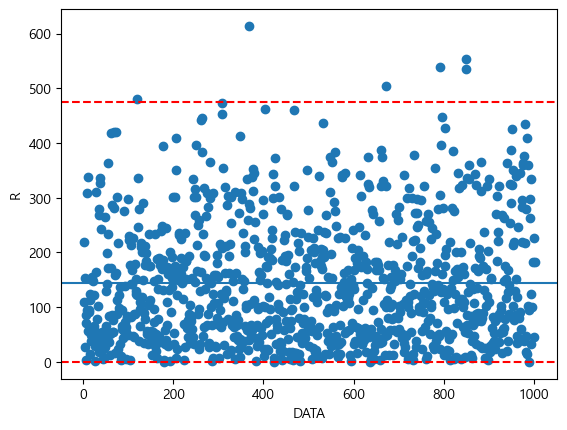

In [63]:
# moving range 관리도
df_mr = df_raw[['temp']]
df_mr['R'] = df['temp'].diff()
df_mr['R'] = np.abs(df_mr['R'])
df = df.dropna()
plt.scatter(df.index, df_mr.R, marker = 'o')
plt.xlabel('DATA')
plt.ylabel('R')
plt.axhline(y = np.mean(df_mr['R']),linestyle = '-', label = 'CL')
plt.axhline(y = np.mean(df_mr['R']) + 3*np.std(df_mr['R']),linestyle = '--',color = 'red', label = 'UCL')
if (np.mean(df_mr['R']) -3 * np.std(df_mr['R'])) < 0:
    plt.axhline( y = 0, linestyle = 'dashed', color = 'red', label = 'LCL')
else:
    plt.axhline(y = np.mean(df_mr['R']) + - 3*np.std(df_mr['R']),linestyle = 'dashed',color = 'red', label = 'LCL');

# 관리상한을 벗어나는 data가 존재하므로 불안정한 process를 가짐

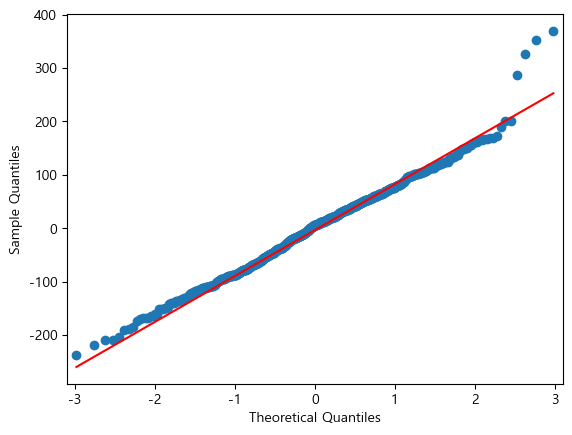

In [65]:
# 잔차 정규성 검정
qqplot(reg_result.resid, line = 'q');

## 최종모델 회귀식
### -2662 + 4.65SLABwide + 4.05SLABthick -2.1RolljoblinLT -31SHEARinLT

In [68]:
y_pred = reg_result.predict(df_test)
print('평가용 데이터의 설명력 : ', r2_score(df_test['temp'],y_pred))

평가용 데이터의 설명력 :  0.6460998821742661


In [70]:
# 공정능력 
# LSL = 300  USL 없음
LSL = 300
X_mean = np.mean(df_raw['temp'])
X_std = np.std(df_raw['temp'])
Cpk = (X_mean - LSL) / (3 * X_std)
Cpk.round(4)


0.4359

In [72]:
# 정규성 검정
statistic , p = stats.shapiro(df_raw['temp'])
statistic, p
## p-value가 2.088412713874277e-07로 0.05보다 작으므로 temp변수는 비 정규성을 띈다.

(0.987774670124054, 2.088412713874277e-07)

In [74]:
# t-test 1sample test with SLABwide, SHEARinLT
df_label_1 = df_raw[df_raw['label'] == 1]
df_label_2 = df_raw[df_raw['label'] == 2]
t_result = stats.ttest_ind(df_label_1['temp'],df_label_2['temp'])
t , p = t_result.statistic.round(3), t_result.pvalue.round(3)

t,p
# 1, 2 로 나눈 temp 에 차이가 있는가
# pvalue 가 0.0으로 0.5보다 작기 때문에 temp가 300이상인 평균과, temp가 300미만인 평균에는 차이가 있다.

(20.27, 0.0)

## 카이제곱 검정

In [77]:
ctab = pd.crosstab(index = df_raw['label'], columns = 'temp')
ctab

col_0,temp
label,
1,908
2,93


In [79]:
# 카이제곱 검정
chi, pval, dof, expected = stats.chi2_contingency(ctab)
chi, pval, dof, expected

(0.0,
 1.0,
 0,
 array([[908.],
        [ 93.]]))

<Axes: >

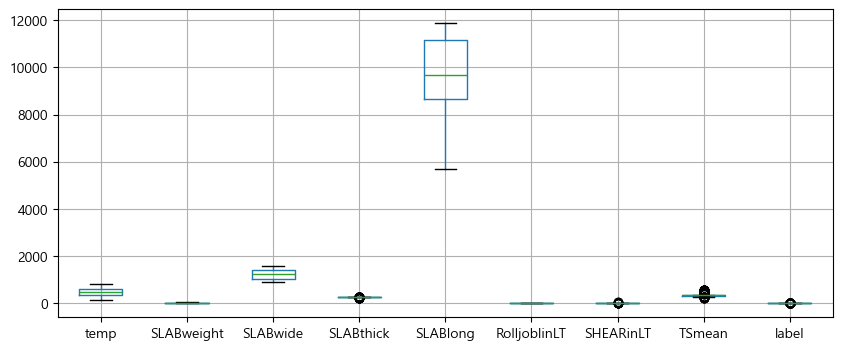

In [81]:
df_raw.boxplot(figsize = (10,4))

<Axes: >

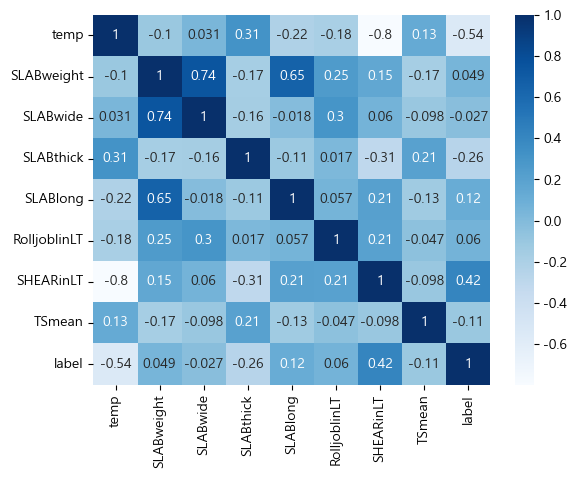

In [82]:
# 상관계수 히트맵
df_cor = df_raw.corr(method = 'pearson')
sns.heatmap(df_cor, annot = True, cmap = 'Blues')

# temp / SHEARinLT = -0.797 | temp / SLABwide = 0.741